# **BONUS**

In [5]:
!pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 11.9 MB/s eta 0:00:00


In [6]:
# from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time

In [7]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3,3]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.final_reward = 0
        self.reward_dict = {(0,0):0,(0,1):0,(0,2):5,(0,3):0
                ,(1,0):0,(1,1):-3,(1,2):0,(1,3):0
                ,(2,0):0,(2,1):0,(2,2):-1,(2,3):0
                ,(3,0):0,(3,1):5,(3,2):0,(3,3):10}


        
    def reset(self, **kwargs):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3,3]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.final_reward = 0
        self.reward_dict = {(0,0):0,(0,1):0,(0,2):5,(0,3):0
                ,(1,0):0,(1,1):-3,(1,2):0,(1,3):0
                ,(2,0):0,(2,1):0,(2,2):-1,(2,3):0
                ,(3,0):0,(3,1):5,(3,2):0,(3,3):10}
        observation = self.state.flatten()

        return observation

    def step(self, action):

      if action == 0:
        self.agent_pos[0] += 1
      if action == 1:
        self.agent_pos[0] -= 1
      if action == 2:
        self.agent_pos[1] += 1
      if action == 3:
        self.agent_pos[1] -= 1

      self.agent_pos = np.clip(self.agent_pos, 0, 3)

      self.state = np.zeros((4,4))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()

      reward = int(self.reward_dict[tuple(self.agent_pos)])
      if reward!=0:
        self.reward_dict[tuple(self.agent_pos)] = 0

      self.final_reward += reward
      self.timestep += 1

      terminated = True if (self.timestep >= self.max_timesteps) or (np.all(self.agent_pos==self.goal_pos)) else False
      
      return observation, reward, terminated
      
    def render(self):
      fig, ax = plt.subplots()
      ax.imshow(self.state)
      ax.set_xticks([0.5, 1.5, 2.5, 3.5])
      ax.set_yticks([0.5, 1.5, 2.5, 3.5])
      ax.grid(True)
      for i in range(self.state.shape[0]):
          for j in range(self.state.shape[1]):
              if self.reward_dict[i, j]!=0:
                ax.text(j, i, self.reward_dict[i, j], ha='center', va='center',color='white')
      plt.show()


In [8]:
class NSARSA:
    def __init__(self, env, alpha=0.27, gamma=0.97, epsilon=0.89,decay_factor=0.9):
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_factor = decay_factor
        # Create an empty dictionary to store the Q-values
        self.Q = np.zeros((self.observation_space.n,self.action_space.n))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space.n)
        else:
            return np.argmax(self.Q[int(state),:])
    def update_Q_2(self, state, action, reward, next_state, next_action):
      predict = self.Q[state, action]
      target = reward + self.gamma * self.Q[next_state, self.choose_action(next_state)]
      self.Q[state, action] = self.Q[state, action] + self.alpha * (target - predict)

In [9]:
def run_Nsarsa(env, agent, gridStates, num_episodes=30):
    episode_reward=[]
    epsilon_over_episodes = []
    
    for episode in range(num_episodes):
        obs = env.reset()
        first_pos = gridStates.get(tuple(env.agent_pos))
        first_action = agent.choose_action(first_pos)
        terminated = False
        
        while not terminated:
            next_obs, reward, terminated = env.step(first_action)
            next_pos = gridStates.get(tuple(env.agent_pos))
            next_action = agent.choose_action(next_pos)
            agent.update_Q_2(first_pos, first_action, reward, next_pos, agent.choose_action(next_pos))
            epsilon_over_episodes.append(agent.epsilon)
            
            if agent.epsilon>0.01:
                agent.epsilon = agent.epsilon * agent.decay_factor
            else:
                agent.epsilon = 0.01
            first_pos, first_action = next_pos, next_action
            
        if np.all(env.agent_pos == env.goal_pos):
            print("Gotcha")
            env.render()
            print(agent.Q)
        
        episode_reward.append(env.final_reward)
    
    return episode_reward, epsilon_over_episodes


In [10]:
def plot_rewards_and_epsilon(episode_reward, epsilon_over_episodes):
    # Plot episode reward
    plt.figure(figsize=(8, 4))
    plt.plot(episode_reward, label='Episode Reward')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Episode - Reward')
    plt.legend()
    plt.show()

    # Plot epsilon over episodes
    plt.figure(figsize=(8, 4))
    plt.plot(epsilon_over_episodes, label='Epsilon')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')
    plt.legend()
    plt.show()

    # Plot cumulative rewards
    x_values = np.arange(len(episode_reward))
    cumulative_rewards = np.cumsum(episode_reward)
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, cumulative_rewards, label='Cumulative Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title('Cumulative Rewards over Time')
    plt.legend()
    plt.show()



Gotcha


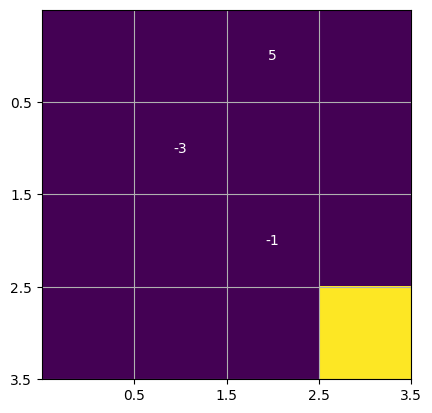

[[7.48449215 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [7.73011013 0.         0.         1.89955525]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [8.0540722  0.         0.         1.56448453]
 [6.16081076 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [4.75019895 5.31822784 8.80070239 5.36563193]
 [2.86745354 3.03835475 0.         8.78325992]
 [0.         0.         2.7        0.        ]
 [0.         0.         0.         0.        ]]
Gotcha


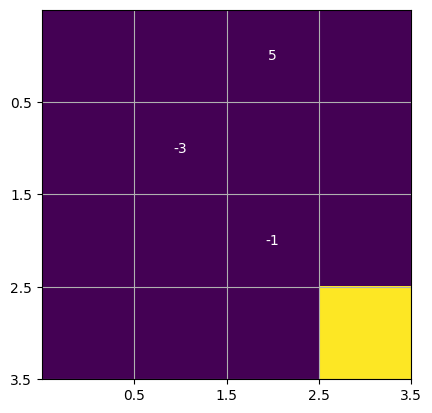

[[8.13224868 2.06274065 0.         1.96018849]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [8.15877708 0.         0.         1.89955525]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [8.28238396 0.         0.         1.56448453]
 [7.40697506 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [5.87478843 5.31822784 8.87436483 6.93509083]
 [5.80925737 2.79700617 0.70713    8.88444994]
 [0.         0.         4.671      0.        ]
 [0.         0.         0.         0.        ]]
Gotcha


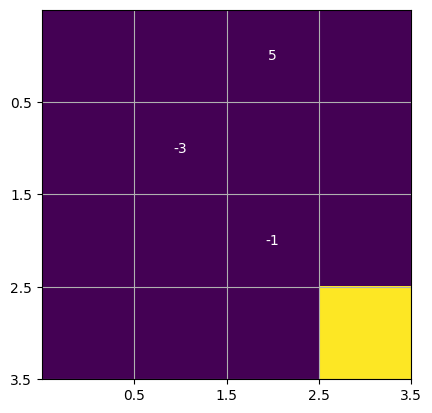

[[7.80913992 2.06274065 0.         1.96018849]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [8.11643452 0.         0.         1.89955525]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [8.54844159 0.         0.         3.28263006]
 [7.7000446  0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [6.7484345  5.31822784 9.90631711 6.93509083]
 [5.80925737 3.98170127 1.7395398  9.25272281]
 [0.         0.         6.10983    0.        ]
 [0.         0.         0.         0.        ]]
Gotcha


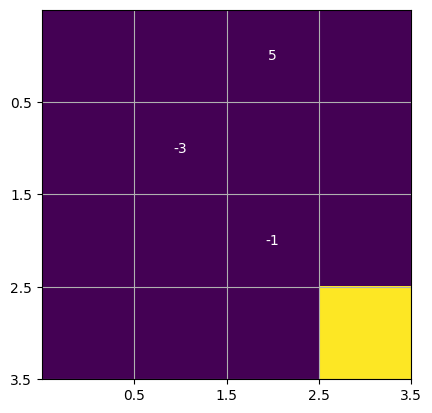

[[7.68172553 2.06274065 0.         3.38461329]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [8.18839854 0.         0.         1.89955525]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [8.57642482 0.         0.         3.28263006]
 [7.7000446  0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [6.44509885 6.16123851 9.94817469 7.40949922]
 [6.58914057 3.98170127 2.87002853 8.62426617]
 [0.         0.         7.1601759  0.        ]
 [0.         0.         0.         0.        ]]


In [20]:
env = GridEnvironment()
agent = NSARSA(env)
gridStates = {(0,0):0,(0,1):1,(0,2):2,(0,3):3
                ,(1,0):4,(1,1):5,(1,2):6,(1,3):7
                ,(2,0):8,(2,1):9,(2,2):10,(2,3):11
                ,(3,0):12,(3,1):13,(3,2):14,(3,3):15}

episode_reward, epsilon_over_episodes = run_Nsarsa(env, agent, gridStates, num_episodes=300)

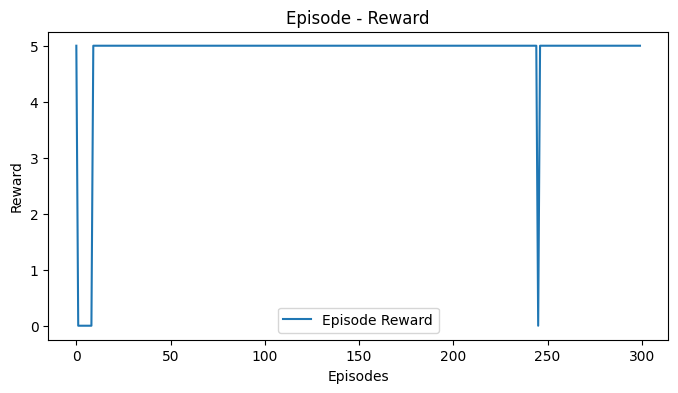

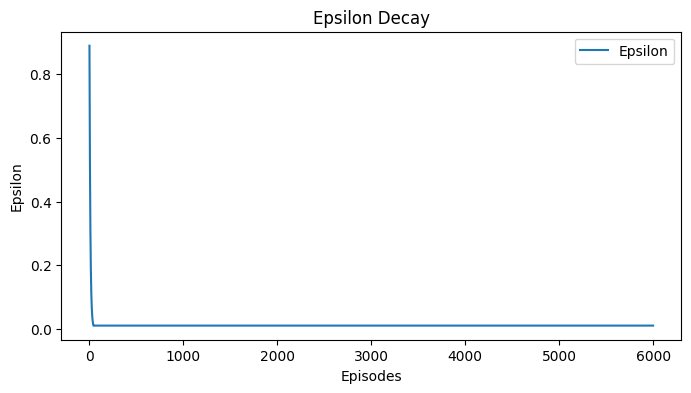

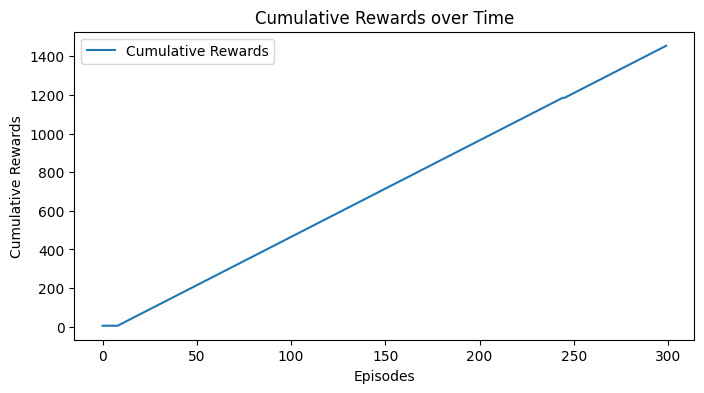

In [13]:
plot_rewards_and_epsilon(episode_reward, epsilon_over_episodes)